# Anitápolis TFA multiple Inversions

This notebook performs the inversion using Levenberg-Marquadt's algorithm of total field anomaly (TFA).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import os
import pandas as pd

from fatiando.vis import mpl

/home/leonardo/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [2]:
from datetime import date
today = date.today()
# dd/mm/YY
d4 = today.strftime("%b-%d-%Y")

### Auxiliary functions

In [3]:
import sys
sys.path.insert(0, '../../code')

import mag_polyprism_functions as mfun

# Input

### Importing model parameters

In [4]:
# output of inversion
inversion = dict()

In [5]:
data = pd.read_csv('anitapolis_decimated_tfa_residual_cut.txt', skipinitialspace=True, delim_whitespace=True)

In [6]:
data['GPSALT'] = - data['GPSALT'] + 800

In [7]:
mask = (data['GPSALT'].get_values()<0.)
data = data[mask]

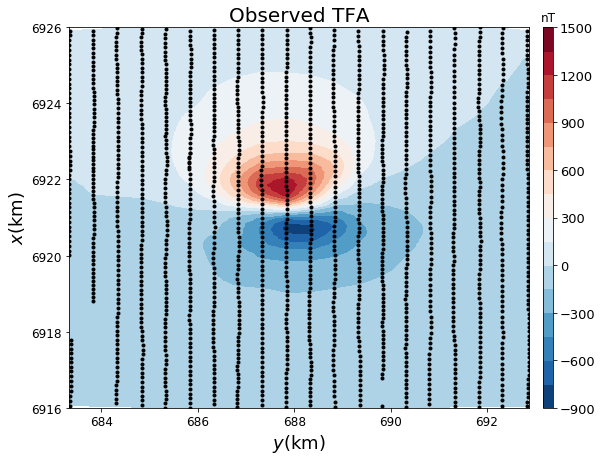

In [8]:
plt.figure(figsize=(10,7))
plt.title('Observed TFA', fontsize=20)
plt.tricontourf(data['Y'], data['X'], data['mag_res1'], 20, cmap='RdBu_r').ax.tick_params(labelsize=12)
plt.plot(data['Y'], data['X'], 'k.')
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
#estimate = mpl.polygon(model0[0], '.-r', xy2ne=True)
#estimate.set_label('Initial estimate')
clb.ax.set_title('nT')
mpl.m2km()
plt.show()

In [9]:
xp = data['X'].get_values()
yp = data['Y'].get_values()
zp = data['GPSALT'].get_values()
alt = data['ALTURA'].get_values()
dobs = data['mag_res1'].get_values()

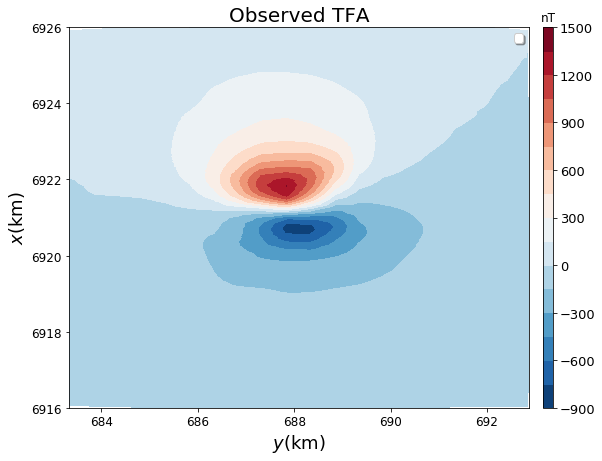

In [10]:
plt.figure(figsize=(10,7))
plt.title('Observed TFA', fontsize=20)
plt.tricontourf(yp, xp, dobs, 20, cmap='RdBu_r').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1)
plt.show()

In [11]:
np.min(zp)

-688.01

### Parameters of the initial model

In [12]:
M = 20 # number of vertices per prism
L = 6 # number of prisms
P = L*(M+2) + 1 # number of parameters

#figura
incs = -21.
decs = -11.
int_min = 5.
int_max = 14.
intensity = np.linspace(int_min, int_max, 10)

# depth to the top, thickness and radius
z0_min = 0.
z0_max = 360.
z0 = np.linspace(z0_min, z0_max, 10)
dz = 630.
r = 700.

x0 = 6921000.
y0 = 688000.

# main field
inc, dec = [-37.05, -18.17]

In [13]:
z0

array([  0.,  40.,  80., 120., 160., 200., 240., 280., 320., 360.])

In [14]:
intensity

array([ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.])

### Limits

In [15]:
# limits for parameters in meters
rmin = 10.
rmax = 1200.
y0min = 687000.
y0max = 699000.
x0min = 6916000.
x0max = 6923000.
dzmin = 10.
dzmax = 1000.

mmin, mmax = mfun.build_range_param(M, L, rmin, rmax, x0min, x0max, y0min, y0max, dzmin, dzmax)

### Variation

In [16]:
# variation for derivatives
deltax = 0.01*np.max(100.)
deltay = 0.01*np.max(100.)
deltar = 0.01*np.max(100.)
deltaz = 0.01*np.max(100.)

### Outcropping parameters

In [17]:
# outcropping body parameters
m_out = np.zeros(M + 2)
#m_out = model['param_vec'][:M+2]

### Folder to save the results

In [18]:
#mypath = 'l1-tfa-inversion/multiple-'+d4
mypath = 'l1-tfa-inversion/multiple-reg-54475/'
if not os.path.isdir(mypath):
   os.makedirs(mypath)

In [19]:
mypath

'l1-tfa-inversion/multiple-reg-56586/'

### Regularization parameters

In [20]:
#lamb = th*0.01 # Marquadt's parameter
lamb = 10.0
dlamb = 10.      # step for Marquadt's parameter

a1 = 1.0e-5  # adjacent radial distances within each prism
a2 = 1.0e-4   # vertically adjacent radial distances
a3 = 0.     # outcropping cross-section
a4 = 0.     # outcropping origin
a5 = 1.0e-4    # vertically adjacent origins
a6 = 1.0e-7   # zero order Tikhonov on adjacent radial distances
a7 = 1.0e-5     # zero order Tikhonov on thickness of each prism

In [21]:
delta = np.array([deltax, deltay, deltar, deltaz])
alpha = np.array([a1, a2, a3, a4, a5, a6, a7])

In [22]:
itmax = 30
itmax_marq = 10
tol = 1.0e-4     # stop criterion

### Inversion

In [23]:
inversion_results = []
for j, z in enumerate(z0):
    for k, i in enumerate(intensity):
        alpha = np.array([a1, a2, a3, a4, a5, a6, a7])
        print 'inversion: %d  top: %d  intensity: %2.f' % (j*z0.size + k, z, i)
        model0, m0 = mfun.initial_cylinder(M, L, x0, y0, z, dz, r, inc, dec, incs, decs, i)
        d_fit, m_est, model_est, phi_list, model_list, res_list = mfun.l1_levmarq_tf(
            xp, yp, zp, m0, M, L, delta,
            itmax, itmax_marq, lamb,
            dlamb, tol, mmin, mmax,
            m_out, dobs, inc, dec,
            model0[0].props, alpha, z, dz
        )
        inversion_results.append([m_est, phi_list, model_list, dobs - d_fit])

inversion: 0  top: 0  intensity:  5
it:  0   it_marq:  0   lambda: 1e+01   init obj.: 8.13269e+01  fin obj.: 5.60436e+01
it:  1   it_marq:  0   lambda: 1e+00   init obj.: 5.60436e+01  fin obj.: 5.66348e+01
it:  1   it_marq:  1   lambda: 1e+01   init obj.: 5.60436e+01  fin obj.: 5.14193e+01
it:  2   it_marq:  0   lambda: 1e+00   init obj.: 5.14193e+01  fin obj.: 5.85765e+01
it:  2   it_marq:  1   lambda: 1e+01   init obj.: 5.14193e+01  fin obj.: 5.08195e+01
it:  3   it_marq:  0   lambda: 1e+00   init obj.: 5.08195e+01  fin obj.: 5.90072e+01
it:  3   it_marq:  1   lambda: 1e+01   init obj.: 5.08195e+01  fin obj.: 4.99437e+01
it:  4   it_marq:  0   lambda: 1e+00   init obj.: 4.99437e+01  fin obj.: 6.12594e+01
it:  4   it_marq:  1   lambda: 1e+01   init obj.: 4.99437e+01  fin obj.: 4.88872e+01
it:  5   it_marq:  0   lambda: 1e+00   init obj.: 4.88872e+01  fin obj.: 5.82032e+01
it:  5   it_marq:  1   lambda: 1e+01   init obj.: 4.88872e+01  fin obj.: 4.83424e+01
it:  6   it_marq:  0   lambda

# Results

In [24]:
inversion['x'] = xp
inversion['y'] = yp
inversion['z'] = zp
inversion['observed_data'] = dobs

In [25]:
inversion['x'].size

1597

In [26]:
inversion['inc_dec'] = [incs, decs]
inversion['z0'] = z0
inversion['initial_dz'] = dz
inversion['intial_r'] = r
inversion['limits'] = [rmin, rmax, x0min, x0max, y0min, y0max, dzmin, dzmax]
inversion['regularization'] = np.array([a1, a2, a3, a4, a5, a6, a7])
inversion['tol'] = tol
inversion['main_field'] = [inc, dec]
inversion['intensity'] = intensity

In [27]:
inversion['results'] = inversion_results

In [28]:
file_name = mypath+'/inversion.pickle'
with open(file_name, 'w') as f:
    pickle.dump(inversion, f)

In [29]:
mypath

'l1-tfa-inversion/multiple-reg-56586/'

###### 